## Set up all the packages we need

In [39]:
import os, json, pickle

import numpy as np
from matplotlib import pyplot as plt

from enterprise import constants as const
from enterprise.pulsar import Pulsar
from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import parameter
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise.signals import gp_bases
from enterprise_extensions import blocks, model_utils
import glob

from enterprise_extensions.chromatic.solar_wind import solar_wind, createfourierdesignmatrix_solar_dm


from enterprise_extensions.blocks import common_red_noise_block

## Grab the data (tiny 3 pulsar PTA from 3 of the best MPTA pulsars)

In [2]:
datadir = "./data_dir"
parfiles = sorted(glob.glob(datadir + '/*par'))
timfiles = sorted(glob.glob(datadir + '/*tim'))

#### Creates the enterprise pulsar objects

In [3]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem="DE440")
    psrs.append(psr)

#### Grab the white noise parameters (not sampled over)

In [4]:
noisefile = "./noise_files/MPTA_WN_models.json"

In [5]:
wn_params = {}
if noisefile is not None:
    with open(noisefile, 'r') as fp:
        wn_params.update(json.load(fp))

In [6]:
wn_params

{'J1903-7051_KAT_MKBF_efac': 1.02225256735,
 'J1903-7051_basis_ecorr_KAT_MKBF_log10_ecorr': -6.9812107153100005,
 'J1909-3744_KAT_MKBF_efac': 0.9968764379,
 'J1909-3744_basis_ecorr_KAT_MKBF_log10_ecorr': -7.35003416485,
 'J1909-3744_KAT_MKBF_log10_tnequad': -6.900722886747,
 'J2241-5236_KAT_MKBF_efac': 1.052512869474,
 'J2241-5236_basis_ecorr_KAT_MKBF_log10_ecorr': -7.479470525598}

#### Set up any additional models we need

In [7]:
def dm_noise(log10_A,gamma,Tspan,components=30,option="powerlaw"):
    """
    A term to account for stochastic variations in DM. It is based on spin
    noise model, with Fourier amplitudes depending on radio frequency nu
    as ~ 1/nu^2.
    """
    nfreqs = 30
    if option=="powerlaw":
    #pl = utils.powerlaw(log10_A=log10_A, gamma=gamma, components=components)
        pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
    #pl = enterprise.signals.gp_priors.powerlaw_no_components(log10_A=log10_A, gamma=gamma)

    #elif option=="turnover":
    #  fc = parameter.Uniform(self.params.sn_fc[0],self.params.sn_fc[1])
    #  pl = powerlaw_bpl(log10_A=log10_A, gamma=gamma, fc=fc,
    #                    components=components)
    dm_basis = utils.createfourierdesignmatrix_dm(nmodes = components,
                                                Tspan=Tspan)
    dmn = gp_signals.BasisGP(pl, dm_basis, name='dm_gp')

    return dmn

#### Set our PTA timespan

In [8]:
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

#### Set how to assign the white noise parameters

In [9]:
selection = selections.Selection(selections.by_backend)

### Define the common noise we want to find
- Here we have a spatially-uncorrelated common spectrum red noise process

In [10]:
crn = common_red_noise_block(psd='powerlaw', prior='log-uniform',
                components=10, orf=None, name='gw')

#### Each pulsar has noise that we know about, grab those models and assign them to the pulsars
- It is good practice to search over extra red noise to clean up possible spectral leakage
- We aren't doing that here because it takes a fair bit longer
- We are using a model that only considers DM noise, the actual noise of the pulsars (so far as we know) is in the file that is commented out
- We are also only using 30 components. The correct number to use here is up for debate and depends on the fluctuation frequency of the noise!

In [11]:
#psr_models = "./noise_files/MPTA_noise_models.json"

psr_models = "./noise_files/MPTA_wrong_noise.json"


models = []

model_json = json.load(open(psr_models))
modelkeys = list(model_json.keys())
wn_json = json.load(open(noisefile))
wnkeys = list(wn_json.keys())

In [12]:
for p in psrs:
    tm = gp_signals.MarginalizingTimingModel(use_svd=True)
    s=tm

    wnmodels = [ wn_model.split("_")[-1] for wn_model in wnkeys if p.name in wn_model ]

    # Get list of models
    psrmodels = [ psr_model for psr_model in modelkeys if p.name in psr_model ][0].split("_")[1:]
    components = 30


    efac = parameter.Constant()
    ecorr = parameter.Constant()
    equad = parameter.Constant()
    
    if "t2equad" in wnmodels or "tnequad" in wnmodels:
        ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
        s += ef
        eq = white_signals.TNEquadNoise(log10_tnequad=equad, selection=selection)
        s += eq
    else:
        ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
        s += ef

    if "ecorr" in wnmodels:
        ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr,selection=selection)
        s += ec


    for i, pm in enumerate(psrmodels):

        if pm == "RN" or pm == "RED":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_red = parameter.Uniform(-20, -12)
                gamma_red = parameter.Uniform(0, 7)
                pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
                rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan)
                s += rn
            elif i+1 == len(psrmodels):
                log10_A_red = parameter.Uniform(-20, -12)
                gamma_red = parameter.Uniform(0, 7)
                pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
                rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan)
                s += rn


        if pm =="DM":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_dm = parameter.Uniform(-20, -12)
                gamma_dm = parameter.Uniform(0, 7)
                dm = dm_noise(log10_A=log10_A_dm,gamma=gamma_dm,Tspan=Tspan,components=components,option="powerlaw")
                s += dm
            elif i+1 == len(psrmodels):
                log10_A_dm = parameter.Uniform(-20, -12)
                gamma_dm = parameter.Uniform(0, 7)
                dm = dm_noise(log10_A=log10_A_dm,gamma=gamma_dm,Tspan=Tspan,components=components,option="powerlaw")
                s += dm 

        if pm == "CHROM":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Uniform(0,7)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom
            elif i+1 == len(psrmodels):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Uniform(0,7)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom

        if pm == "CHROMWIDE" or ( pm == "CHROM" and ( i+1 < len(psrmodels) and psrmodels[i+1] == "WIDE" ) ):
            log10_A_chrom_prior = parameter.Uniform(-20, -12)
            gamma_chrom_prior = parameter.Uniform(0, 7)
            chrom_gp_idx = parameter.Uniform(0,14)
            chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
            idx = chrom_gp_idx
            components = components
            chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                    idx=idx)
            chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_wide_gp')
            s += chrom

        if pm == "CHROMCIDX":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Constant(4)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom
            elif i+1 == len(psrmodels):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Constant(4)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom
        
        if pm == "SW":
            n_earth = parameter.Uniform(0, 20)
            deter_sw = solar_wind(n_earth=n_earth)
            mean_sw = deterministic_signals.Deterministic(deter_sw, name='n_earth')

            Tspan = psr.toas.max() - psr.toas.min()
            max_cadence = 60
            sw_components = components

            log10_A_sw = parameter.Uniform(-10, 1)
            gamma_sw = parameter.Uniform(-4, 4)
            sw_prior = utils.powerlaw(log10_A=log10_A_sw, gamma=gamma_sw)
            sw_basis = createfourierdesignmatrix_solar_dm(nmodes=sw_components, Tspan=Tspan)

            sw = mean_sw + gp_signals.BasisGP(sw_prior, sw_basis, name='gp_sw')

            s += sw
        
        if pm == "SWDET":
            n_earth = parameter.Uniform(0, 20)
            deter_sw = solar_wind(n_earth=n_earth)
            mean_sw = deterministic_signals.Deterministic(deter_sw, name='n_earth')

            sw = mean_sw

            s += sw
        
    if "SW" not in psrmodels and "SWDET" not in psrmodels:
        n_earth = parameter.Constant(4)
        deter_sw = solar_wind(n_earth=n_earth)
        mean_sw = deterministic_signals.Deterministic(deter_sw, name='n_earth')

        sw = mean_sw

        s += sw
    
    ## For adding extra red noise where needed ##
    
    # if len([ pn for pn in psrmodels if "RN" in pn ]) == 0:
    #     log10_A_red = parameter.Uniform(-20, -12)
    #     gamma_red = parameter.Uniform(0, 7)
    #     pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
    #     rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan)
    #     s += rn

    s +=crn
    models.append(s(p))

#### Set up the full PTA as an enterprise PTA object and print the summary to check what's being sampled

In [13]:
pta = signal_base.PTA(models)
pta.set_default_params(wn_params)

In [14]:
pta

<Enterprise PTA object: J1903-7051, J1909-3744, J2241-5236>

In [15]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.11

Signal Name                              Signal Class                   no. Parameters      
J1903-7051_marginalizing_linear_timing_model TimingModel                    0                   

params:
__________________________________________________________________________________________
J1903-7051_measurement_noise             MeasurementNoise               0                   

params:
J1903-7051_KAT_MKBF_efac:Constant=1.02225256735                                           
__________________________________________________________________________________________
J1903-7051_basis_ecorr                   EcorrBasisModel                0                   

params:
J1903-7051_basis_ecorr_KAT_MKBF_log10_ecorr:Constant=-6.9812107153100005                  
__________________________________________________________________________________________
J1903-7051_dm_gp                         BasisGP                        2                   

params:
J19

#### 8 parameters are being sampled over just 3 pulsars with simplified models!
- Scale that up to 85 pulsars and you start to see the computational intensity

## PTA is made! Now to sample:

In [16]:
from enterprise_extensions import hypermodel

Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


#### The hypermodel framework allows different models (i.e. different correlated signals) to be compared!
- Here we only use it to assess a single uncorrelated model. For many models, add them to the pta_dict below:

In [17]:
pta_dict = dict.fromkeys(np.arange(1))
pta_dict[0] = pta

In [18]:
hyper_model = hypermodel.HyperModel(pta_dict)
x0 = hyper_model.initial_sample()
ndim = len(x0)


We would use many more samples for a proper analysis, but assign the number below

In [19]:
N = int(1e5)

In [20]:
#params = hyper_model.param_names

In [21]:
model_label = "toy_pta"

In [22]:
outDir = "./results_dir/{0}".format(model_label)

In [23]:
try:
    os.mkdir(outDir)
    print("Made directory")
except:
    print("Already there")
    pass

Already there


In [24]:
sampler = hyper_model.setup_sampler(outdir=outDir, resume=True)

Adding red noise prior draws...

Adding DM GP noise prior draws...



#### Sample time!
- Should take about ~3 minutes

In [25]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

/home/mmiles/.conda/envs/mpippcgw/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 18.353406 s Acceptance rate = 0.31956Adding DE jump with weight 50
Finished 99.00 percent in 163.929100 s Acceptance rate = 0.426172
Run Complete


### And we're done! In reality this would take days to complete, but let's see if we can find a common signal in the data

In [26]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])
ind = list(pta.param_names).index('gw_log10_A')

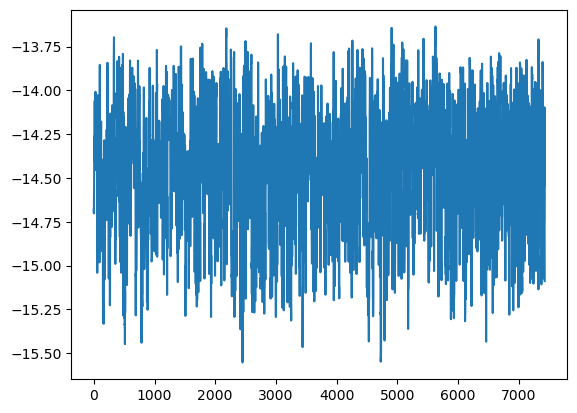

In [27]:
plt.plot(chain[burn:, ind])

Text(0, 0.5, 'PDF')

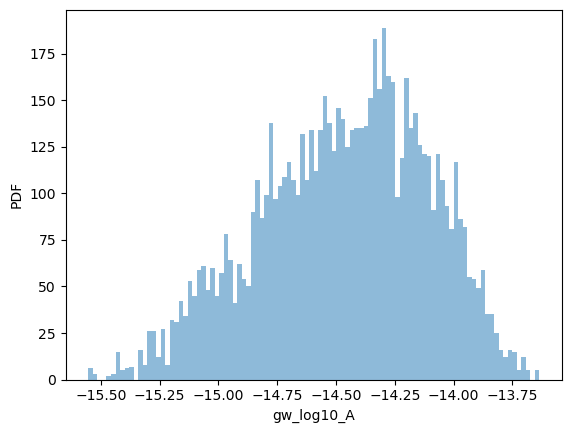

In [28]:
plt.hist(chain[burn:,ind], 100, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('gw_log10_A')
plt.ylabel('PDF')

#### What about the correlated signal?

With only three pulsars it's unlikely that we'll be able to see a spatially correlated signal, but we can still test this and compare the models in the same way that we did to test the signals that are in the single pulsars earlier

In [29]:
#Define a correlated signal with the below:
hd = common_red_noise_block(psd='powerlaw', prior='log-uniform',
                components=10, orf="hd", name='hd')

In [30]:
models2 = []
for p in psrs:
    tm = gp_signals.MarginalizingTimingModel(use_svd=True)
    s=tm

    wnmodels = [ wn_model.split("_")[-1] for wn_model in wnkeys if p.name in wn_model ]

    # Get list of models
    psrmodels = [ psr_model for psr_model in modelkeys if p.name in psr_model ][0].split("_")[1:]
    components = 30


    efac = parameter.Constant()
    ecorr = parameter.Constant()
    equad = parameter.Constant()
    
    if "t2equad" in wnmodels or "tnequad" in wnmodels:
        ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
        s += ef
        eq = white_signals.TNEquadNoise(log10_tnequad=equad, selection=selection)
        s += eq
    else:
        ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
        s += ef

    if "ecorr" in wnmodels:
        ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr,selection=selection)
        s += ec


    for i, pm in enumerate(psrmodels):

        if pm == "RN" or pm == "RED":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_red = parameter.Uniform(-20, -12)
                gamma_red = parameter.Uniform(0, 7)
                pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
                rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan)
                s += rn
            elif i+1 == len(psrmodels):
                log10_A_red = parameter.Uniform(-20, -12)
                gamma_red = parameter.Uniform(0, 7)
                pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
                rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan)
                s += rn


        if pm =="DM":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_dm = parameter.Uniform(-20, -12)
                gamma_dm = parameter.Uniform(0, 7)
                dm = dm_noise(log10_A=log10_A_dm,gamma=gamma_dm,Tspan=Tspan,components=components,option="powerlaw")
                s += dm
            elif i+1 == len(psrmodels):
                log10_A_dm = parameter.Uniform(-20, -12)
                gamma_dm = parameter.Uniform(0, 7)
                dm = dm_noise(log10_A=log10_A_dm,gamma=gamma_dm,Tspan=Tspan,components=components,option="powerlaw")
                s += dm 

        if pm == "CHROM":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Uniform(0,7)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom
            elif i+1 == len(psrmodels):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Uniform(0,7)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom

        if pm == "CHROMWIDE" or ( pm == "CHROM" and ( i+1 < len(psrmodels) and psrmodels[i+1] == "WIDE" ) ):
            log10_A_chrom_prior = parameter.Uniform(-20, -12)
            gamma_chrom_prior = parameter.Uniform(0, 7)
            chrom_gp_idx = parameter.Uniform(0,14)
            chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
            idx = chrom_gp_idx
            components = components
            chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                    idx=idx)
            chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_wide_gp')
            s += chrom

        if pm == "CHROMCIDX":
            if ( i+1 < len(psrmodels) and psrmodels[i+1] != "WIDE" ):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Constant(4)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom
            elif i+1 == len(psrmodels):
                log10_A_chrom_prior = parameter.Uniform(-20, -12)
                gamma_chrom_prior = parameter.Uniform(0, 7)
                chrom_gp_idx = parameter.Constant(4)
                chrom_model = utils.powerlaw(log10_A=log10_A_chrom_prior, gamma=gamma_chrom_prior)
                idx = chrom_gp_idx
                components = components
                chrom_basis = gp_bases.createfourierdesignmatrix_chromatic(nmodes=components,
                                                                        idx=idx)
                chrom = gp_signals.BasisGP(chrom_model, chrom_basis, name='chrom_gp')
                s += chrom
        
        if pm == "SW":
            n_earth = parameter.Uniform(0, 20)
            deter_sw = solar_wind(n_earth=n_earth)
            mean_sw = deterministic_signals.Deterministic(deter_sw, name='n_earth')

            Tspan = psr.toas.max() - psr.toas.min()
            max_cadence = 60
            sw_components = components

            log10_A_sw = parameter.Uniform(-10, 1)
            gamma_sw = parameter.Uniform(-4, 4)
            sw_prior = utils.powerlaw(log10_A=log10_A_sw, gamma=gamma_sw)
            sw_basis = createfourierdesignmatrix_solar_dm(nmodes=sw_components, Tspan=Tspan)

            sw = mean_sw + gp_signals.BasisGP(sw_prior, sw_basis, name='gp_sw')

            s += sw
        
        if pm == "SWDET":
            n_earth = parameter.Uniform(0, 20)
            deter_sw = solar_wind(n_earth=n_earth)
            mean_sw = deterministic_signals.Deterministic(deter_sw, name='n_earth')

            sw = mean_sw

            s += sw
        
    if "SW" not in psrmodels and "SWDET" not in psrmodels:
        n_earth = parameter.Constant(4)
        deter_sw = solar_wind(n_earth=n_earth)
        mean_sw = deterministic_signals.Deterministic(deter_sw, name='n_earth')

        sw = mean_sw

        s += sw
    
    ## For adding extra red noise where needed ##
    
    # if len([ pn for pn in psrmodels if "RN" in pn ]) == 0:
    #     log10_A_red = parameter.Uniform(-20, -12)
    #     gamma_red = parameter.Uniform(0, 7)
    #     pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
    #     rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan)
    #     s += rn

    s +=hd
    models2.append(s(p))

In [31]:
pta2 = signal_base.PTA(models2)
pta2.set_default_params(wn_params)

Let's set up the hypermodel to compare

In [32]:
new_pta_dict = dict.fromkeys(np.arange(2))
new_pta_dict[0] = pta
new_pta_dict[1] = pta2

hyper_model = hypermodel.HyperModel(new_pta_dict)
x0 = hyper_model.initial_sample()
ndim = len(x0)

In [33]:
N = int(1e5)

model_label = "toy_compare_pta"

outDir = "./results_dir/{0}".format(model_label)

try:
    os.mkdir(outDir)
    print("Made directory")
except:
    print("Already there")
    pass



Already there


In [34]:
sampler = hyper_model.setup_sampler(outdir=outDir, resume=True)

Adding red noise prior draws...

Adding DM GP noise prior draws...



##### Even with 3 pulsars this will take much, much longer to sample

This is part of the reason we're okay with using a frequentist analysis technique to assess this

#### Let's move over to OS_notebook.ipynb while this is sampling

In [35]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 10.00 percent in 56.213220 s Acceptance rate = 0.34369Adding DE jump with weight 50
Finished 99.00 percent in 554.782825 s Acceptance rate = 0.423051
Run Complete


In [36]:

# Make a quick function so we don't have to write this out anymore
def quick_plotter(param):
    chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
    burn = int(0.25 * chain.shape[0])
    param_ind = list(hyper_model.param_names).index(param)
    med_param = np.median(chain[burn:, param_ind])
    if param != "nmodel":
        plt.title("{0}: {1:.2f}".format(param, med_param))
        plt.plot(chain[burn:, param_ind])
    
        plt.figure()
        plt.hist(chain[burn:,param_ind], 100, histtype='stepfilled', 
                 lw=2, color='C0', alpha=0.5)
        plt.xlabel(param)
        plt.ylabel('PDF')
        plt.figure()
    else:
        plt.title("{0}: {1:.2f}".format(param, med_param))
        plt.plot(chain[:, param_ind])
    
        plt.figure()
        plt.hist(chain[:,param_ind], 100, histtype='stepfilled', 
                 lw=2, color='C0', alpha=0.5)
        plt.xlabel(param)
        plt.ylabel('PDF')
        plt.figure()

/tmp/ipykernel_3677610/1965619408.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


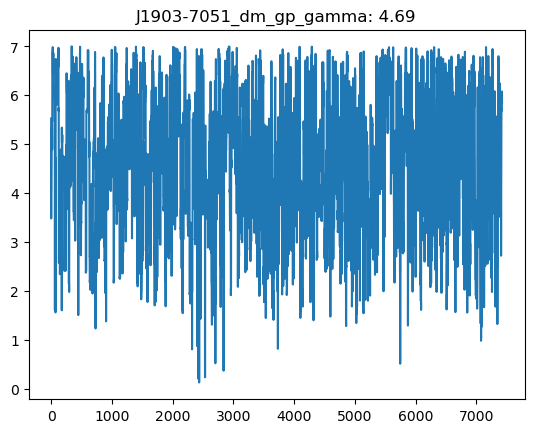

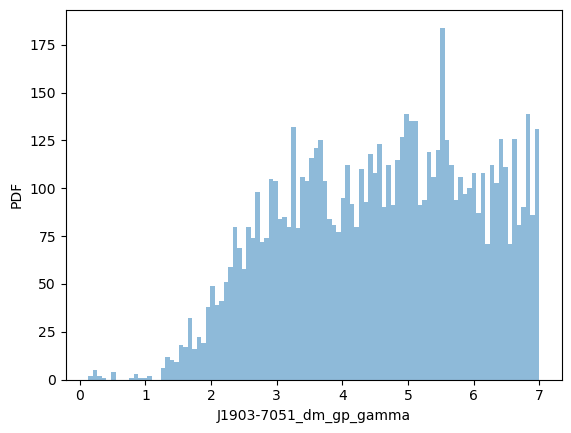

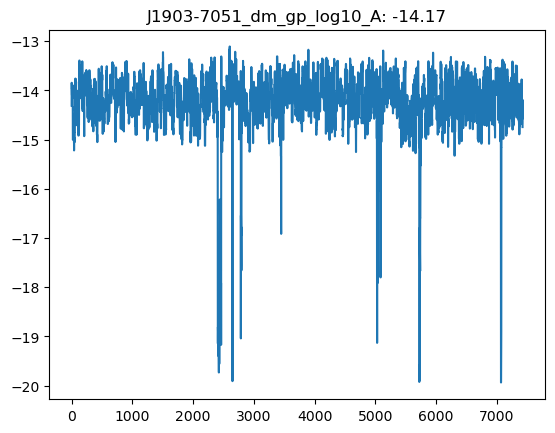

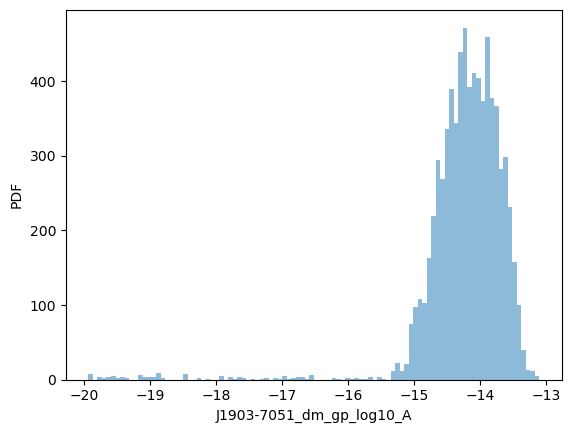

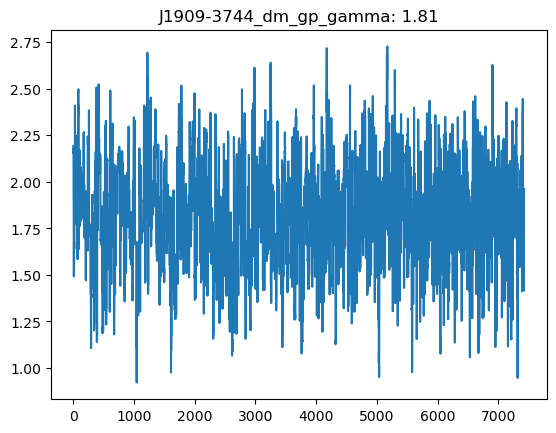

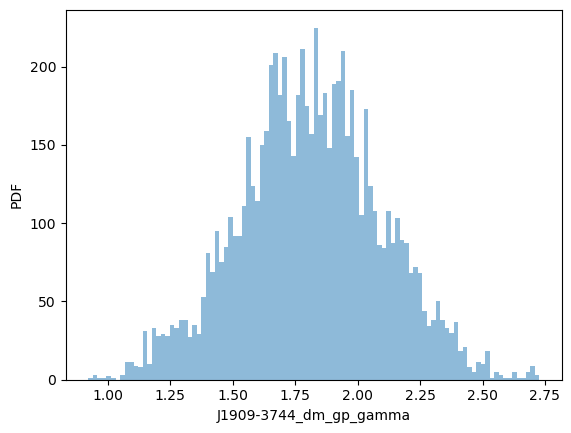

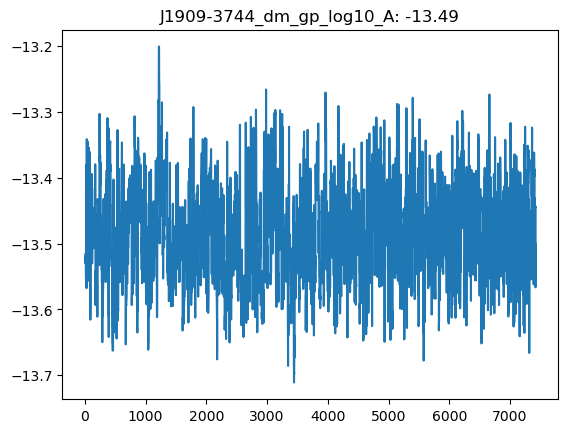

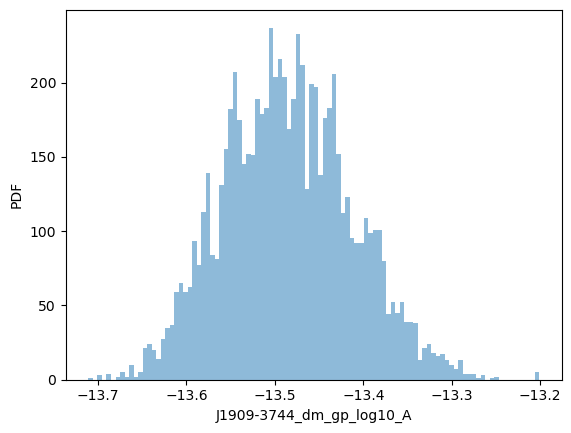

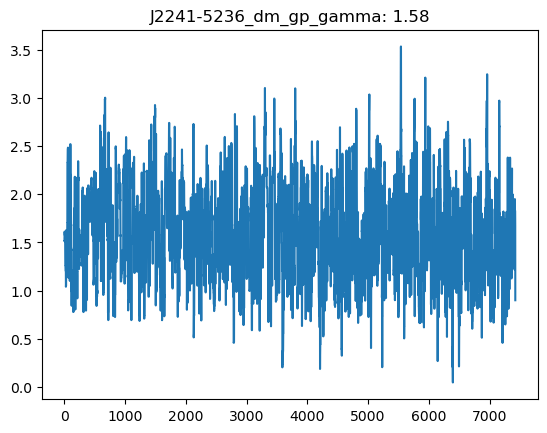

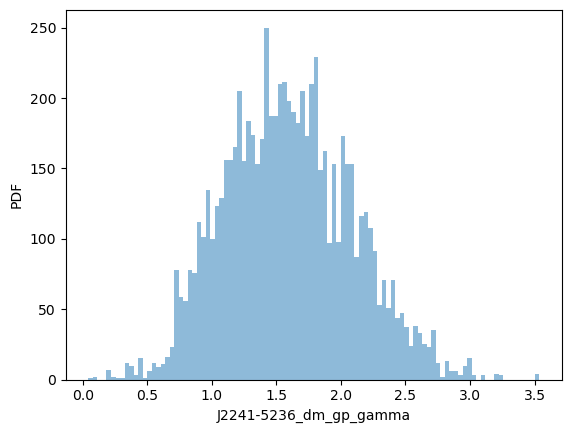

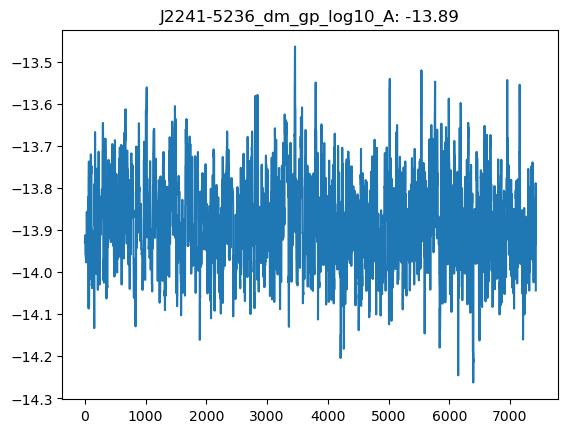

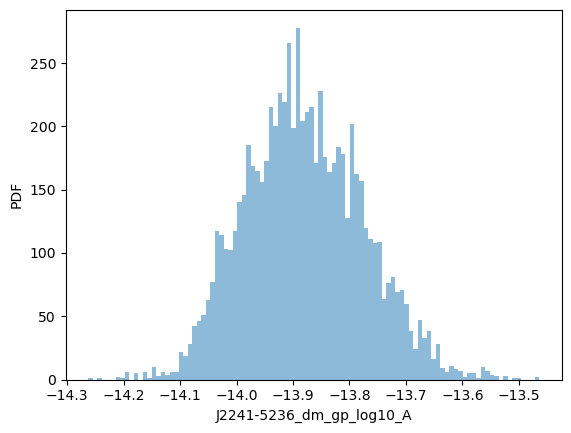

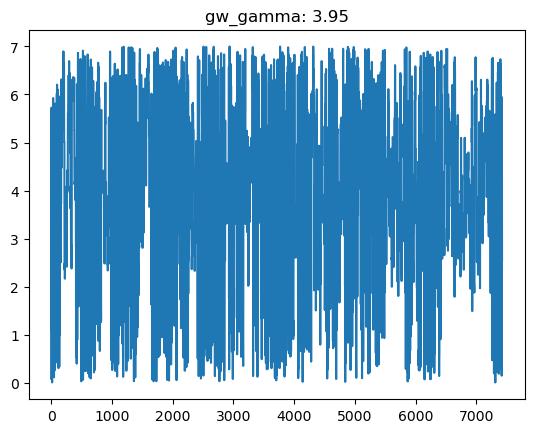

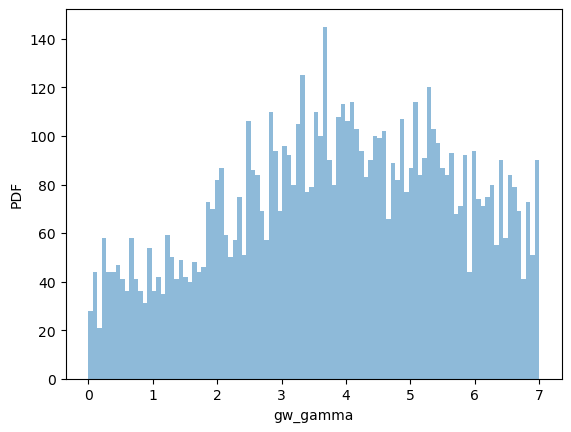

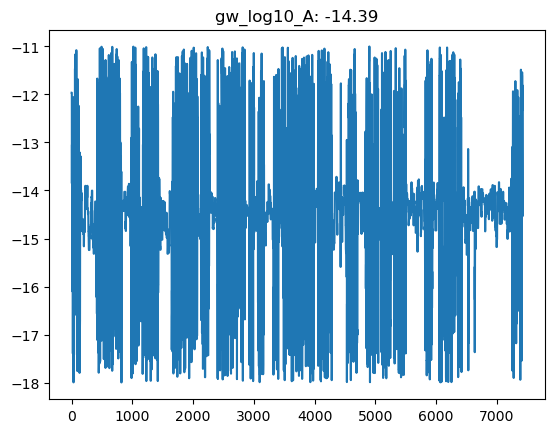

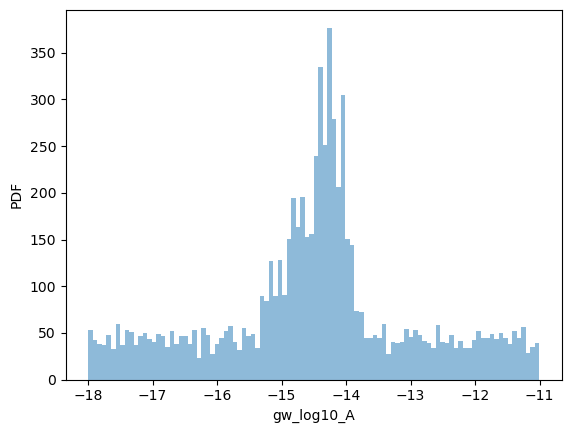

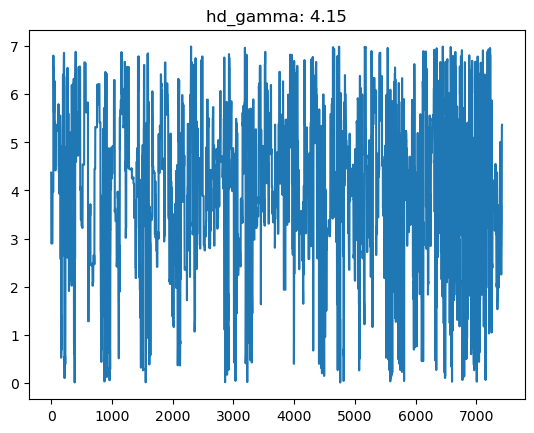

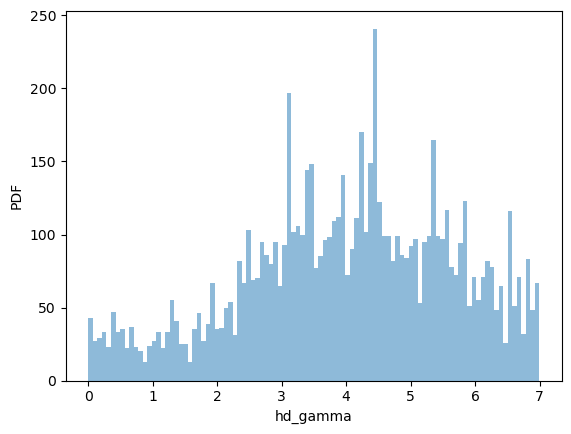

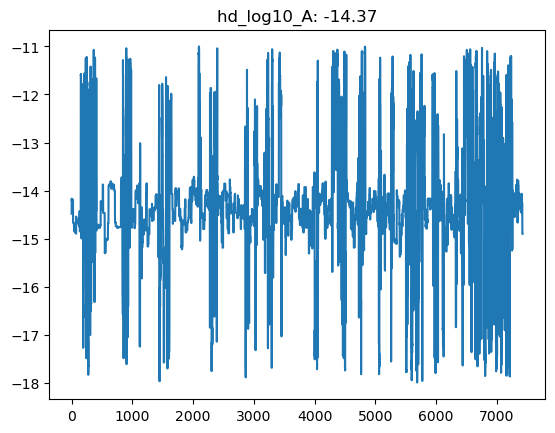

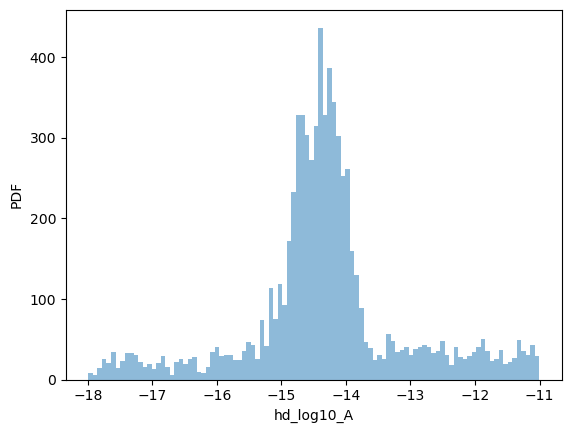

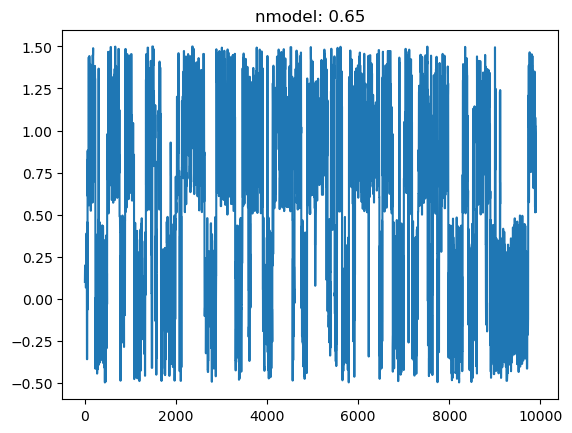

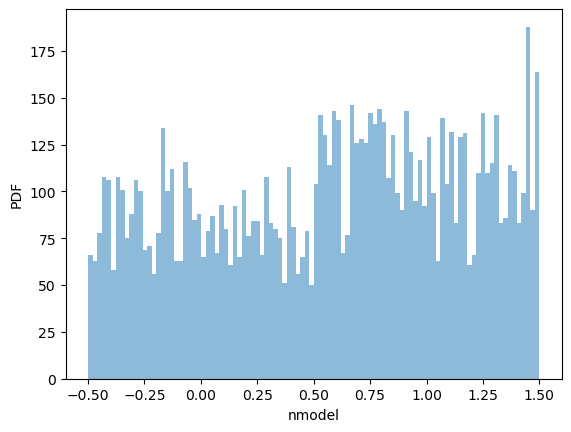

<Figure size 640x480 with 0 Axes>

In [37]:
for param in hyper_model.param_names:
    quick_plotter(param)
    plt.clf()

In [40]:
ind_nmodel = list(hyper_model.param_names).index("nmodel")
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])
bf, unc = model_utils.odds_ratio(chain[burn:, ind_nmodel], models=[0,1])
print(bf, unc)

1.459423650215303 0.347160838782694


### And there you go! The beginnings of a PTA GW analysis

What did you get with the Bayes factor comparison? 

Is this what you expected?

Why? Why not?